In [5]:
import pandas as pd
import os
from tqdm import tqdm
from utils import avg, evidence_to_mask, text_len_scatter

def to_data_df(df, data_dir, balance=False):
    data_df = []
    columns = ['text','classification', 'rationale','query']
    
    if balance:
        majority_class = []
        for i, c in enumerate (train['classification']):
            if c == "SUPPORTS": 
                majority_class.append(i)
        import random
        remove = random.sample(majority_class, 133)
    else:
        remove = []
                
    for i in tqdm(range(len(df))):
        if i in remove:
            continue
        df_row = df.loc[i]
        doc_ids = df_row['docids']
        query = df_row['query']
        evidence_list = df_row['evidences']
        if evidence_list:
            evidence_list = [x for xx in evidence_list for x in xx]
        classification = df_row['classification']
        
        text = ''
        for doc in doc_ids:
            file = f'{data_dir}/docs/{doc}'
            if os.path.isfile(file):
                f = open(file, 'r', encoding="utf-8") 
                for line in f.readlines():
                    text += line.rstrip() + ' '
            else:
                print("???")
                print(file)
                quit()
        
        tokens = text.split()
        rationale_mask = evidence_to_mask(tokens, evidence_list)
        
        # joining text and query with [SEP]
#         QA = f"{query} [SEP] {text}"
#         rationale_mask = [1]*(len(query.split())+1) + rationale_mask
        
#         QA = f"{text}[SEP] {query}"
#         rationale_mask = rationale_mask + [1]*(len(query.split())+1)

        QA = text
#         QA = rationale_check(text,rationale_mask)
         
        data_df.append([QA, classification, rationale_mask, query])
    data_df = pd.DataFrame(data_df, columns=columns)
    return data_df
    
#     data_df_shuffled=data_df.sample(frac=1).reset_index(drop=True)
#     return data_df_shuffled

In [2]:
dataset = "scifact"

In [3]:
data_dir = f'../data/{dataset}'
train = pd.read_json(f'{data_dir}/train.jsonl', lines=True)
test = pd.read_json(f'{data_dir}/test.jsonl', lines=True)
val = pd.read_json(f'{data_dir}/val.jsonl', lines=True)

In [6]:
train_data_df = to_data_df(train, data_dir)
# train_data_df.to_csv(f"{dataset}/train.csv",index_label="id")
test_data_df = to_data_df(test, data_dir)
# test_data_df.to_csv(f"{dataset}/test.csv",index_label="id")
val_data_df = to_data_df(val, data_dir)
# val_data_df.to_csv(f"{dataset}/val.csv",index_label="id")

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 338.31it/s]


{333: 3,
 300: 2,
 510: 1,
 186: 9,
 295: 2,
 636: 3,
 171: 8,
 159: 4,
 197: 9,
 422: 2,
 468: 2,
 179: 1,
 148: 4,
 172: 8,
 331: 6,
 166: 11,
 429: 3,
 152: 6,
 660: 1,
 857: 1,
 241: 2,
 173: 8,
 343: 3,
 226: 7,
 368: 2,
 386: 6,
 239: 4,
 492: 4,
 189: 1,
 139: 5,
 135: 5,
 133: 2,
 497: 1,
 550: 4,
 367: 3,
 187: 4,
 157: 2,
 106: 1,
 168: 5,
 181: 5,
 190: 8,
 230: 1,
 184: 3,
 137: 3,
 280: 1,
 193: 2,
 163: 8,
 648: 1,
 585: 1,
 286: 1,
 167: 8,
 478: 4,
 265: 4,
 224: 3,
 390: 3,
 379: 4,
 217: 5,
 127: 2,
 151: 1,
 210: 3,
 619: 2,
 314: 2,
 170: 5,
 408: 1,
 392: 7,
 378: 2,
 313: 2,
 236: 2,
 402: 1,
 482: 2,
 177: 6,
 162: 5,
 248: 3,
 396: 2,
 669: 1,
 164: 11,
 306: 2,
 169: 13,
 371: 3,
 437: 6,
 372: 5,
 457: 5,
 247: 7,
 165: 8,
 180: 2,
 175: 22,
 237: 2,
 174: 5,
 199: 3,
 204: 3,
 196: 2,
 132: 2,
 353: 2,
 394: 1,
 227: 1,
 609: 2,
 223: 8,
 633: 3,
 318: 1,
 219: 2,
 191: 4,
 154: 4,
 112: 2,
 264: 1,
 495: 1,
 340: 2,
 488: 2,
 426: 2,
 341: 2,
 590: 3,
 460: 

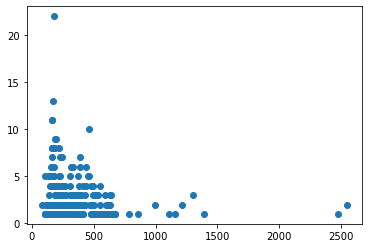

In [7]:
text_len_scatter(train_data_df,test_data_df,val_data_df)

In [35]:
train['evidences'][2]

[[{'text': 'RESULTS Mean baseline homocysteine level was 24.0 micromol/L in the vitamin group and 24.2 micromol/L in the placebo group .',
   'docid': '33409100',
   'start_token': 238,
   'end_token': 258,
   'start_sentence': 8,
   'end_sentence': 9}],
 [{'text': 'CONCLUSION Treatment with high doses of folic acid and B vitamins did not improve survival or reduce the incidence of vascular disease in patients with advanced chronic kidney disease or end-stage renal disease .',
   'docid': '33409100',
   'start_token': 469,
   'end_token': 503,
   'start_sentence': 12,
   'end_sentence': 13}]]

# SANITY CHECK

In [27]:
def rationale_check(text,rationale):
    tokens = text.split()
    out = ""
    for i, b in enumerate(rationale):
        if b:
           out += tokens[i] + " "
    return out

In [21]:
data_df = test_data_df
import json

def reduce_by_alpha(text, rationale, fidelity_type="sufficiency"):
    reduced_text = ""
    # whitespace tokenization
    tokens = text.split()

    for idx in range(len(tokens)):
        try:
            if fidelity_type == "sufficiency" and rationale[idx] >= 0.5:
                reduced_text = reduced_text + tokens[idx] + " "
            elif fidelity_type == "comprehensiveness" and rationale[idx] < 0.5:
                reduced_text = reduced_text + tokens[idx] + " "
        except Exception as e:
            if fidelity_type == "comprehensiveness":
                reduced_text = reduced_text + tokens[idx] + " "

    # removed the last space from the text
    if len(reduced_text) > 0:
        reduced_text = reduced_text[:-1]

    return reduced_text

data_df = data_df[data_df['rationale'].notna()]
data_df.reset_index(drop=True, inplace=True)


data_df["sufficiency_text"] = data_df[
    ["text", "rationale"]].apply(lambda s: reduce_by_alpha(*s, fidelity_type="sufficiency"), axis=1)
data_df["comprehensiveness_text"] = data_df[
    ["text", "rationale"]].apply(lambda s: reduce_by_alpha(*s, fidelity_type="comprehensiveness"), axis=1)

In [38]:
data_df['sufficiency_text'][0]

'1,000 genomes project enables mapping of genetic sequence variation consisting of rare variants with larger penetrance effects than common variants. [SEP] We propose as an alternative explanation that variants much less common than the associated one may create " synthetic associations " by occurring , stochastically , more often in association with one of the alleles at the common site versus the other allele . We show that they are not only possible , but inevitable , and that under simple but reasonable genetic models , they are likely to account for or contribute to many of the recently identified signals reported in genome-wide association studies . In conclusion , uncommon or rare genetic variants can easily create synthetic associations that are credited to common variants , and this possibility requires careful consideration in the interpretation and follow up of GWAS signals .'

In [41]:
test.iloc[0]

annotation_id                                                     3
query             1,000 genomes project enables mapping of genet...
evidences         [[{'text': 'We propose as an alternative expla...
classification                                             SUPPORTS
query_type                                                      NaN
docids                                                   [14717500]
Name: 0, dtype: object

In [216]:
train_data_df.iloc[0]['text']

'1 in 5 million in UK have abnormal PrP positivity. [SEP] OBJECTIVES To carry out a further survey of archived appendix samples to understand better the differences between existing estimates of the prevalence of subclinical infection with prions after the bovine spongiform encephalopathy epizootic and to see whether a broader birth cohort was affected , and to understand better the implications for the management of blood and blood products and for the handling of surgical instruments . DESIGN Irreversibly unlinked and anonymised large scale survey of archived appendix samples . SETTING Archived appendix samples from the pathology departments of 41 UK hospitals participating in the earlier survey , and additional hospitals in regions with lower levels of participation in that survey . SAMPLE 32,441 archived appendix samples fixed in formalin and embedded in paraffin and tested for the presence of abnormal prion protein ( PrP ) . RESULTS Of the 32,441 appendix samples 16 were positive 

# DATA STATS

In [11]:
def generate_class_stats(train_df, test_df, val_df):
    text_lens_0 = []
    text_lens_1 = []
    rationale_lens_0 = []
    rationale_lens_1 = []
    rationale_percent_0 = []
    rationale_percent_1 = []
    class_distribution = [0,0]
    for df in [train_df, test_df, val_df]:
        for i in range(len(df)):
            df_row = df.loc[i]
            clas = df_row['classification']
            text = df_row['text']
            rationale = df_row['rationale']
            query = df_row['query']
            
            query_len = len(query.split())
            text_len = len(text.split()) - query_len - 1
            rationale_len = rationale.count(1) - query_len - 1
            rationale_percent = rationale_len/text_len
            if clas == "REFUTES":
                text_lens_0.append(text_len)
                rationale_lens_0.append(rationale_len)
                rationale_percent_0.append(rationale_percent)
                class_distribution[0] += 1
            else:
                text_lens_1.append(text_len)
                rationale_lens_1.append(rationale_len)
                rationale_percent_1.append(rationale_percent)
                class_distribution[1] += 1
                
    all_stats = {"text_lens_0": text_lens_0,
                 "text_lens_1": text_lens_1,
                 "text_lens_all":text_lens_0 + text_lens_1,
                 "rationale_lens_0":rationale_lens_0,
                 "rationale_lens_1":rationale_lens_1,
                 "rationale_lens_all":rationale_lens_0 + rationale_lens_1,
                 "rationale_percent_0": rationale_percent_0,
                 "rationale_percent_1": rationale_percent_1,
                 "rationale_percent_all": rationale_percent_0 + rationale_percent_1,
                 "class_distr":[class_distribution[0]/sum(class_distribution),class_distribution[1]/sum(class_distribution)]
                }
    return all_stats

In [12]:
all_stats = generate_class_stats(train_data_df,test_data_df,val_data_df)
for key,val in all_stats.items():
    print(f"{key}: {avg(val)}")
print(all_stats["class_distr"])

text_lens_0: 338.1097046413502
text_lens_1: 290.7872807017544
text_lens_all: 306.97113997113996
rationale_lens_0: 75.33755274261604
rationale_lens_1: 64.48245614035088
rationale_lens_all: 68.1948051948052
rationale_percent_0: 0.24197325510418663
rationale_percent_1: 0.24247460908892945
rationale_percent_all: 0.24230315036687455
class_distr: 0.5
[0.341991341991342, 0.658008658008658]


In [190]:
rationale_check(train_data_df.iloc[0]['text'],train_data_df.iloc[0]['rationale'])

'RESULTS Of the 32,441 appendix samples 16 were positive for abnormal PrP , indicating an overall prevalence of 493 per million population ( 95 % confidence interval 282 to 801 per million ) . [SEP] 1 in 5 million in UK have abnormal PrP positivity. '

In [191]:
train.iloc[0]['evidences']

[[{'text': 'RESULTS Of the 32,441 appendix samples 16 were positive for abnormal PrP , indicating an overall prevalence of 493 per million population ( 95 % confidence interval 282 to 801 per million ) .',
   'docid': '13734012',
   'start_token': 136,
   'end_token': 170,
   'start_sentence': 4,
   'end_sentence': 5}]]

In [200]:
train_data_df.iloc[0]

text              OBJECTIVES To carry out a further survey of ar...
classification                                              REFUTES
rationale         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
query             1 in 5 million in UK have abnormal PrP positiv...
Name: 0, dtype: object